# Online DA: 
## CESM LME prior/LIM, HadCRUT5 observations

In [2]:
import sys
import numpy as np
import xarray as xr
import scipy.stats as spy
import datetime
import random

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [3]:
sys.path.append("../")
import Online_DA_utils as oda

In [4]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../Online_DA_utils.py'>

In [113]:
t =0
# Select number of years to reconstruct: 
nyears = 155

# Generate times: 
t_total = nyears*12
years = int(1850+np.floor((t_total-1)/12))
time = np.array([datetime.datetime(y, m, 15) for y in np.arange(1850,1850+nyears,1) for m in np.arange(1,13,1)])

limvars = ['tas','psl','zg','tos','sit','sic']
neofs = 300

limname = 'multimod_MPI_GFDL_HadGEM3_CanESM_Amon'
modname = 'cesm_lme_Amon'
tname = 'multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon'
obsname = 'hadCRUT_all'

In [114]:
savename = ('ODA_prior_'+modname+'_LIM_'+limname+'_obs_'+obsname+'_t_0_'+str(t_total)+'_nomj_trainRe.pkl')
savename

'ODA_prior_cesm_lme_Amon_LIM_multimod_MPI_GFDL_HadGEM3_CanESM_Amon_obs_hadCRUT_all_t_0_1860_nomj_trainRe.pkl'

### Load L: 

In [115]:
print('Loading L....')
LIM = oda.load_L(limname)
LIMd = LIM['LIMd']
LIMd.keys()

Loading L....
Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/multimod/LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_validy_1851_1950_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [116]:
Projector_tas = LIMd['E3']['tas']

### Load pseudo observations at HadCRUT locations: 

In [117]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'
obsfilename = 'Hadcrut_data_on_CESMLME_grid_NH.pkl'

had_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]
# had_obs_data_og = had_obs_data['had_on_refgrid'][12:1872,:,:]
# had_obs_data_og = had_obs_data['observations']

#Select obs mask from given timestep in Hadcrut to use throughout:
# had_155_mask = np.where(np.isfinite(had_obs_data_og[0,:,:]),1,0)
# had_obs_data_full = had_155_mask[np.newaxis,:,:]*np.nan_to_num(had_obs_data_og[:,:,:])
# had_obs_data_full[np.logical_not(np.abs(had_obs_data_full)>0)]=np.nan

had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0],
                                                 had_obs_data_full.shape[1]*had_obs_data_full.shape[2])).T
# had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0],
#                                                  had_obs_data_full.shape[1]*had_obs_data_full.shape[2])).T

#had_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

In [118]:
nobs = np.zeros((1860))

for t in range(1860):
    nobs[t] = np.isfinite(had_obs_full_2d[:,t]).sum()

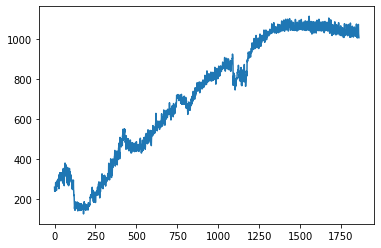

In [119]:
plt.plot(nobs)

In [120]:
np.where(nobs<200)[0].shape

(104,)

In [121]:
had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]

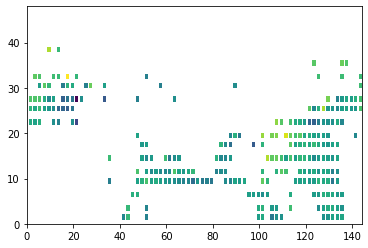

In [122]:
plt.pcolormesh(had_obs_data_full[0,:,:])

In [123]:
had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]
had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0],
                                                 had_obs_data_full.shape[1]*had_obs_data_full.shape[2])).T

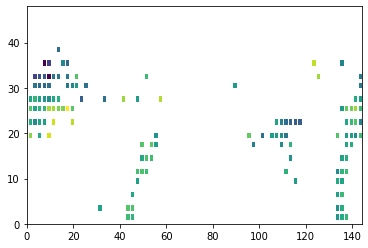

In [124]:
plt.pcolormesh(had_obs_data_full[177,:,:])

In [125]:
had_obs_full_2d[:,0]

array([nan, nan, nan, ..., nan, nan, nan])

In [126]:
# Project HadCRUT to eof space:
eofs_out = LIMd['E3']['tas']/LIMd['standard_factor']['tas']
P_var = np.matmul(eofs_out.T, (LIMd['W_all']['tas'][:,np.newaxis]*np.nan_to_num(had_obs_full_2d)))
Ptrunc = P_var/LIMd['standard_factor']['tas']

In [19]:
#HadCRUT_tas, HadCRUT_lat, HadCRUT_lon, HadCRUT_time = oda.load_HadCRUT5()

## Load initial conditions in eof space: 

In [20]:
priordir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/'
priorname = 'Xb_initial_'+modname+'_300ndof_1651_1850.pkl'
trainname = 'Xb_initial_'+tname+'_300ndof_1850_2473.pkl'

Xb_initial_data = pickle.load(open(priordir+priorname,"rb"))
Xb_initial_allt = Xb_initial_data['Xb_initial']

In [21]:
Xb_train_data = pickle.load(open(priordir+trainname,"rb"))
Xb_train_allt = Xb_train_data['Xb_initial']

In [22]:
ndof_total = 0
limvars = ['tas','psl','zg','tos','sit','sic']
for var in limvars: 
    ndof_total = ndof_total+LIMd['var_dict'][var]['var_ndof']

In [23]:
Pb_initial = LIMd['C_0']

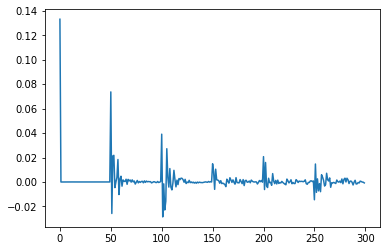

In [24]:
plt.plot(LIMd['C_0'][0,:])

### Build H:
H should be a matrix of size (nobs, nlalo) filled with zeros and ones. One one per column at the ob location. 

In [25]:
had_obs_data_og.shape, had_155_mask.shape

NameError: name 'had_obs_data_og' is not defined

In [109]:
had_mask = np.zeros_like(had_obs_data_full)
had_mask[np.isfinite(had_obs_data_full)] = had_mask[np.isfinite(had_obs_data_full)]+1

In [110]:
had_mask_rand = np.zeros_like((had_obs_full_2d.T))

for t in range(1860):
    true_inds = np.where(np.isfinite(np.reshape(had_obs_data_full[t,:,:],
                                                (had_obs_data_full.shape[1]*had_obs_data_full.shape[2]))))
    
    if true_inds[0].shape[0]>200:
        true_rand = random.sample(list(true_inds[0]),200)
    else: 
        true_rand = true_inds[0]

    had_mask_rand[t,true_rand] = had_mask_rand[t,true_rand]+1
    
had_mask_rand = np.reshape(had_mask_rand,(had_mask_rand.shape[0],had_obs_data_full.shape[1],
                                          had_obs_data_full.shape[2]))
had_mask_rand.shape

IndexError: index 192929 is out of bounds for axis 1 with size 6912

In [111]:
plt.pcolormesh(had_mask_rand[100,:,:])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [136]:
obs_mask = np.where(np.isfinite(had_obs_data_full[12*20:,:,:]),1,0)
ntime = obs_mask.shape[0]

In [137]:
fixed_obs_mask = np.where(np.sum(obs_mask,axis=0)>=ntime,1,0)

In [138]:
fixed_obs_mask.sum()

79

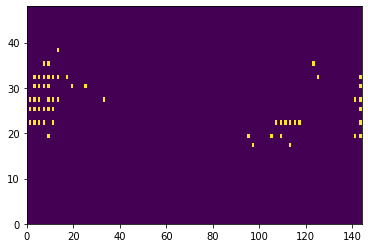

In [98]:
plt.pcolormesh(fixed_obs_mask)

In [150]:
obsname = 'cmip6_mpi_hist_regridlme_Amon'
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'
#obsfilename = 'Hadcrut_data_on_CESMLME_grid_NH.pkl'
obsfilename = 'TAS_pseudo_obs_'+obsname+'_hadCRUT_locations_1851_2005.pkl'

had_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

#had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]
had_obs_data_full = had_obs_data['observations']
# had_obs_data_og = had_obs_data['observations']

#Select obs mask from given timestep in Hadcrut to use throughout:
# had_155_mask = np.where(np.isfinite(had_obs_data_og[:,:,150]),1,0)
# had_obs_data_full = had_155_mask[:,:,np.newaxis]*np.nan_to_num(had_obs_data_og[:,:,:])
# had_obs_data_full[np.logical_not(np.abs(had_obs_data_full)>0)]=np.nan

had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0]*had_obs_data_full.shape[1],
                                                had_obs_data_full.shape[2]))

In [151]:
obs_mask = np.where(np.isfinite(had_obs_data_full[:,:,12*20:]),1,0)
ntime = obs_mask.shape[2]

fixed_obs_mask = np.where(np.sum(obs_mask,axis=2)>=ntime,1,0)
Nobs = fixed_obs_mask.sum()
print('# of obs = '+str(Nobs))

had_mask = np.ones((t_total,fixed_obs_mask.shape[0],fixed_obs_mask.shape[1]))*fixed_obs_mask[np.newaxis,:,:]

# of obs = 79


In [146]:
had_mask_rand = np.zeros_like((had_obs_full_2d.T))

for t in range(1860):
    true_inds = np.where(np.isfinite(np.reshape(had_obs_data_full[:,:,t],
                                                (had_obs_data_full.shape[1]*had_obs_data_full.shape[0]))))

    if true_inds[0].shape[0]>=Nobs:
        true_rand = random.sample(list(true_inds[0]),Nobs)
    else: 
        true_rand = true_inds[0]

    had_mask_rand[t,true_rand] = had_mask_rand[t,true_rand]+1

had_mask = np.reshape(had_mask_rand,(had_mask_rand.shape[0],had_obs_data_full.shape[0],
                                     had_obs_data_full.shape[1]))

In [147]:
had_mask.shape

(1860, 48, 144)

In [28]:
nobs = np.zeros((1860))

for t in range(1860):
    nobs[t] = had_mask_rand[t,:,:].sum()

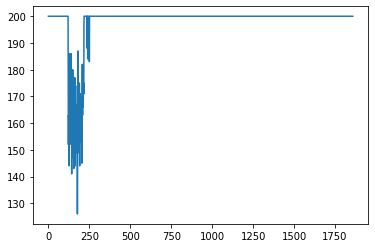

In [29]:
plt.plot(nobs)

In [30]:
E3_all = np.zeros((ndof_total,neofs))
ntrunc = 50

for v,var in enumerate(limvars): 
    E3_all[LIMd['var_dict'][var]['var_inds'],
           int(v*ntrunc):int((v+1)*ntrunc)] = LIMd['E3'][var]/np.sqrt(LIMd['standard_factor'][var])

In [31]:
had_obs_data_full.shape

(1860, 48, 144)

## Initial timestep - Kalman Filtering: 

In [32]:
Xb = np.nan_to_num(Xb_initial_allt[:,-1])
Pb = Pb_initial

In [33]:
t = 0

In [34]:
had_mask[0,:,:].shape

(48, 144)

In [35]:
had_mask.shape, had_mask_rand.shape

((1860, 48, 144), (1860, 48, 144))

In [77]:
H_cap, nobs, ndof = oda.build_H_time(had_mask_rand[0,:,:])

H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

In [37]:
H.shape, U.shape, nobs, had_mask.shape

NameError: name 'U' is not defined

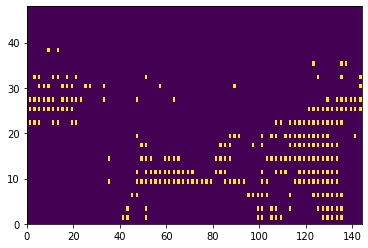

In [38]:
plt.pcolormesh(had_mask[0,:,:])

In [39]:
U = E3_all
H_eof = np.matmul(H,U)

In [40]:
H_eof.shape, Xb_train_allt[:,-had_obs_full_2d.shape[1]:].shape, U.shape, had_obs_full_2d.shape

((200, 300), (300, 1860), (35424, 300), (6912, 1860))

In [41]:
## ---------------------------------------------------------
## BUILD R: 
## ---------------------------------------------------------
Hx = np.matmul(H_eof,Xb_train_allt[:,-had_obs_full_2d.shape[1]:])
Hx_cap = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d))

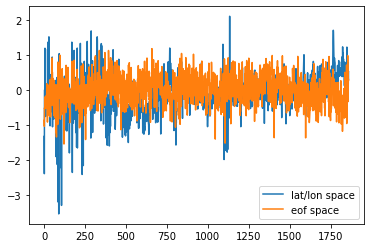

In [42]:
plt.plot(Hx_cap[0,:], label='lat/lon space')
plt.plot(Hx[0,:], label='eof space')
plt.legend()

In [43]:
epsilon.shape, Hx.shape

NameError: name 'epsilon' is not defined

In [44]:
epsilon = Hx_cap - Hx

slope = np.zeros(Hx.shape[0])
for i in range(Hx.shape[0]):
    slope[i],_,_,_,_ = spy.linregress(Hx[i,:],epsilon[i,:])
e = epsilon - slope[:,np.newaxis]*Hx

R = np.matmul(epsilon,epsilon.T)/(epsilon.shape[1]-1)
R_e = np.matmul(e,e.T)/(e.shape[1]-1)

In [73]:
np.mean(np.diag(R_e)), np.mean(np.diag(R))

(1.4559876609005287, 3.2241499593033587)

In [74]:
np.min(np.diag(R_e)), np.min(np.diag(R))

(0.1713669110258304, 0.29211210975731916)

In [75]:
np.max(np.diag(R_e)), np.max(np.diag(R))

(9.066625057788084, 18.62245932563709)

(0, 2.5)

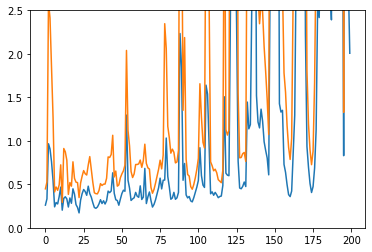

In [72]:
plt.plot(np.diag(R_e))
plt.plot(np.diag(R))
plt.ylim(0,2.5)

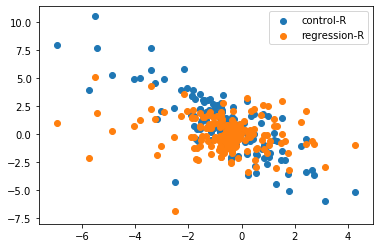

In [46]:
plt.scatter(Hx[:,0],epsilon[:,0],label='control-R')
plt.scatter(Hx[:,0],e[:,0],label='regression-R')
plt.legend()

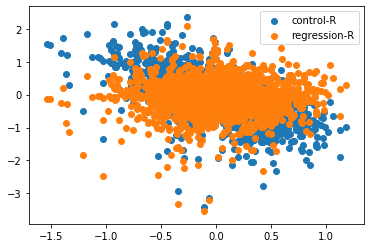

In [47]:
plt.scatter(Hx[0,:],epsilon[0,:],label='control-R')
plt.scatter(Hx[0,:],e[0,:],label='regression-R')
plt.legend()

In [48]:
R_hack = R_e
H_final = H_eof

Y = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d[:,t]))

# obs['obs'] = Y
# #     obs['obs_lat'] = obs_lat
# #     obs['obs_lon'] = obs_lon
# obs_assimilated[t] = obs

In [153]:
H_cap.shape

(200, 6912)

In [154]:
Xa, K, K_den, diff = oda.solver_KF_update(Xb, Pb, Y, R_hack, H_final)

In [155]:
R_hack.max(), R_hack.min(), 

(9.066625057788084, -2.145091354142283)

In [77]:
Pb.max(), Pb.min()

(0.22796173103772252, -0.06662518417607564)

In [160]:
Pa = oda.solver_KF_cov(K,H_final,Pb)

In [161]:
Pa.shape

(300, 300)

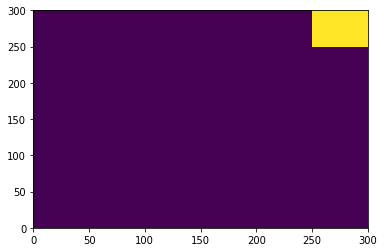

In [167]:
inflation = np.ones_like(Pa)
inflation[-50:,-50:] = inflation[-50:,-50:]*2
plt.pcolormesh(inflation)

In [79]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H_final,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 10.65799463960186
Posterior MSE = 2.074896474000992


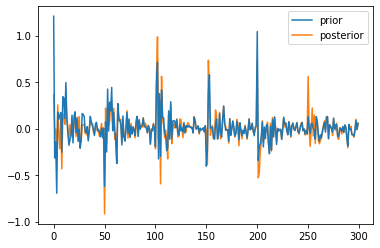

In [80]:
plt.plot(Xb, label='prior',zorder=1)
plt.plot(Xa, label = 'posterior',zorder=0)
plt.legend()

## Forecast Step: 

In [81]:
LIM_Xfcast = oda.LIM_forecast(LIMd,Xa,Pa,1,adjust=False)

Adjust is False...
lag= 1


In [126]:
np.trace(LIM_Xfcast['cov_forecast'])

5.336998019425282

In [82]:
print('R = '+str(R_hack.max()))
print('HPbHT = '+str(np.max(np.matmul(np.matmul(H_final,Pb),H_final.T))))

R = 9.066625057788084
HPbHT = 12.268170464605335


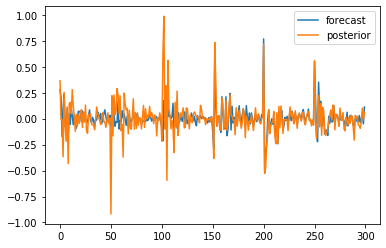

In [83]:
plt.plot(LIM_Xfcast['x_forecast'], label='forecast')
plt.plot(Xa, label = 'posterior')
plt.legend()

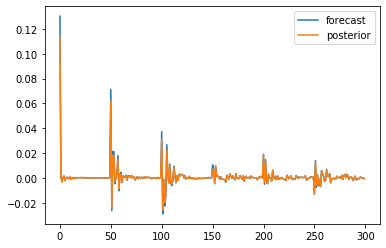

In [157]:
plt.plot(LIM_Xfcast['cov_forecast'][0,:], label='forecast')
plt.plot(Pa[0,:], label = 'posterior')
plt.legend()

### Project HadCRUT data into EOF space: 

In [90]:
eofs_out = LIMd['E3']['tas']/LIMd['standard_factor']['tas']
P_var = np.matmul(eofs_out.T, (LIMd['W_all']['tas'][:,np.newaxis]*np.nan_to_num(had_obs_full_2d)))
Ptrunc = P_var/LIMd['standard_factor']['tas']

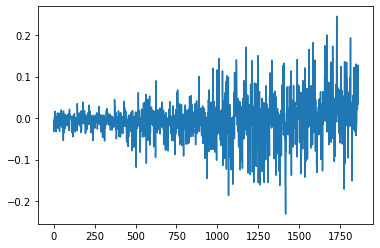

In [92]:
plt.plot(Ptrunc[0,:])

In [106]:
Xb_valid_allt.shape, Ptrunc.shape, eofs_out.shape, had_obs_full_2d.shape

((300, 1860), (50, 1860), (6912, 50), (6912, 1860))

In [98]:
Hadcrut_eofs = np.zeros_like(Xb_valid_allt)
Hadcrut_eofs[0:50,:] = Ptrunc

In [101]:
epsilon.shape

(239, 1860)

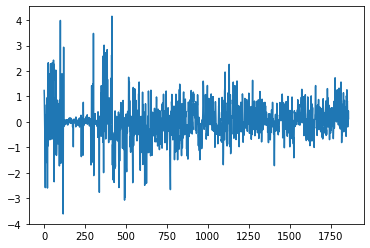

In [104]:
plt.plot(epsilon[100,:])

In [56]:
t=1

In [99]:
Xb_initial = LIM_Xfcast['x_forecast']
Pb = LIM_Xfcast['cov_forecast']

H_cap, nobs, ndof = oda.build_H_time(had_mask[t,:,:])

H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap
H_eof = np.matmul(H,U)

Hx = np.matmul(H_eof,Hadcrut_eofs)
Hx_cap = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d))

epsilon = Hx_cap - Hx
R = np.matmul(epsilon,epsilon.T)/(epsilon.shape[0]-1)

Y = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d[:,t]))

In [58]:
Xa, K, K_den, diff = oda.solver_KF_update(Xb_initial, Pb, Y, R, H_eof)

In [59]:
H_cap.shape, H_eof.shape, Pb.shape, R_hack.shape

((239, 6912), (239, 300), (300, 300), (259, 259))

In [60]:
Pa = oda.solver_KF_cov(K,H_eof,Pb)

In [61]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H_eof/100,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 4.795213884508432
Posterior MSE = 3.3771619484752313


In [195]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)/diff.shape[0]
ratio = (np.diagonal(diffcov)/np.diagonal(K_den))
print('Median Ratio = '+str(np.median(ratio)))
print('Mean Ratio = '+str(np.mean(ratio)))

Median Ratio = 0.0002798221727003975
Mean Ratio = 0.0008543963002324987
